In [1]:
import numpy as np  
import pandas as pd
from numpy import median, percentile
from numpy.random import seed, randint
from sklearn.model_selection import train_test_split
from sklearn import metrics
#from scipy.integrate import cumtrapz
from sklearn.metrics import (roc_auc_score, cohen_kappa_score,confusion_matrix, precision_score,
                             accuracy_score, average_precision_score, f1_score,
                             precision_recall_curve, roc_curve) #, auc, recall_score)
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt              
from inspect import signature
import joblib
from sklearn.calibration import (CalibratedClassifierCV, 
                                 _CalibratedClassifier, calibration_curve)  
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (make_scorer, roc_auc_score) #, cohen_kappa_score,confusion_matrix, precision_score,
#                             accuracy_score, auc, average_precision_score, f1_score,
#                             precision_recall_curve, recall_score, roc_curve)          
import dill
import sys
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("./data/patientData.csv", delimiter=",")

In [3]:
df

,patientunitstayid,gender,age,admissionweight,admissionheight,ethnicity,vitalaperiodicid,observationoffset,noninvasivesystolic,noninvasivediastolic,noninvasivemean,cardioDiagnosis,treated
0,242895,Male,80,101.2,170.18,Caucasian,15957733.0,1102.800000,136.371429,73.028571,87.857143,True,True
1,243097,Male,49,127.0,185.40,Caucasian,17382422.5,1191.789474,128.947368,77.815789,88.815789,True,True
2,243999,Female,70,98.4,157.50,Caucasian,11676875.0,806.041096,101.589041,55.520548,65.945205,True,True
3,244477,Female,55,113.7,165.10,Caucasian,16120409.0,197.000000,112.142857,60.285714,72.285714,False,True
4,246997,Male,62,50.1,172.70,Caucasian,18137589.0,733.131148,96.245902,66.819672,79.147541,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749,3351763,Female,62,134.5,165.10,Caucasian,443446038.5,2876.161765,135.985294,63.323529,89.279412,False,True
1750,3352230,Male,41,127.0,177.80,African American,443136851.0,2360.507246,117.101449,65.260870,84.304348,True,True
1751,3352231,Male,41,127.0,177.80,African American,445040552.0,655.600000,128.000000,71.800000,91.800000,True,True
1752,3352333,Male,72,68.3,177.80,Caucasian,442861118.5,1505.014286,146.600000,81.628571,106.228571,False,False


In [4]:
# Converting categorical variables to numeric
df.gender.loc[df.gender == 'Male'] = 1
df.gender.loc[df.gender == 'Female'] = 0

df.age.loc[df.age == '> 89'] = 89
df.age = df.age.astype(float)

df.ethnicity.loc[df.ethnicity == 'Caucasian'] = 0
df.ethnicity.loc[df.ethnicity == 'Native American'] = 1
df.ethnicity.loc[df.ethnicity == 'African American'] = 2
df.ethnicity.loc[df.ethnicity == 'Hispanic'] = 3
df.ethnicity.loc[df.ethnicity == 'Asian'] = 4
df.ethnicity.loc[df.ethnicity == 'Other/Unknown'] = 5

df.cardioDiagnosis.loc[df.cardioDiagnosis == True] = 1
df.cardioDiagnosis.loc[df.cardioDiagnosis == False] = 0

df.treated.loc[df.treated == True] = 1
df.treated.loc[df.treated == False] = 0


C:\Users\Núria\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
df.ethnicity.nunique()

6

Split data into x y training and x y test sets

In [6]:
df = df.drop(columns = ['patientunitstayid', 'vitalaperiodicid', 'observationoffset']) 
train, test = train_test_split(df, test_size=0.25, random_state=25)

y_train = train['treated']
X_train = train.drop(columns = ['treated'])

y_test = test['treated']
X_test = test.drop(columns = ['treated'])
   
y_train = y_train.astype('int')
y_test = y_test.astype('int')
# All    

X_num = X_train.drop(columns = ['gender','ethnicity','cardioDiagnosis'])

get_numeric_data = FunctionTransformer(lambda x: x[X_num.columns], validate=False)

get_categorical = FunctionTransformer(lambda x: x[['gender','ethnicity','cardioDiagnosis']], validate=False) 

scaler = MinMaxScaler()


In [7]:
df

,gender,age,admissionweight,admissionheight,ethnicity,noninvasivesystolic,noninvasivediastolic,noninvasivemean,cardioDiagnosis,treated
0,1,80.0,101.2,170.18,0,136.371429,73.028571,87.857143,1,1
1,1,49.0,127.0,185.40,0,128.947368,77.815789,88.815789,1,1
2,0,70.0,98.4,157.50,0,101.589041,55.520548,65.945205,1,1
3,0,55.0,113.7,165.10,0,112.142857,60.285714,72.285714,0,1
4,1,62.0,50.1,172.70,0,96.245902,66.819672,79.147541,0,1
...,...,...,...,...,...,...,...,...,...,...
1749,0,62.0,134.5,165.10,0,135.985294,63.323529,89.279412,0,1
1750,1,41.0,127.0,177.80,2,117.101449,65.260870,84.304348,1,1
1751,1,41.0,127.0,177.80,2,128.000000,71.800000,91.800000,1,1
1752,1,72.0,68.3,177.80,0,146.600000,81.628571,106.228571,0,0


In [8]:
df.dtypes

gender                   object
age                     float64
admissionweight         float64
admissionheight         float64
ethnicity                object
noninvasivesystolic     float64
noninvasivediastolic    float64
noninvasivemean         float64
cardioDiagnosis          object
treated                  object
dtype: object

Modeling

In [9]:
# Logistic Regression
lr = LogisticRegression(random_state = 42,tol=1**-4,verbose=1) #,solver='lbfgs') #,class_weight='balanced')

# Random forests
rf = RandomForestClassifier(random_state = 42
                            #,n_jobs =-1 # set The number of jobs to run in parallel -1 means using all processors
                           )

# Neural Network

nn = MLPClassifier(random_state = 42,max_iter=500)

# SVM

svm = SVC(random_state = 42,probability=True) # Whether to enable probability estimates. This must be enabled prior to calling fit, and will slow down that method.

# XGB

xgb = XGBClassifier(random_state = 42)

all_models_list = [lr,
                   rf,
                   nn,
                   svm,
                   xgb]

all_models_names = ['lr',
                    'rf',
                    'nn',
                    'svm',
                    'xgb']

#all_models_list = [rf]

#all_models_names = ['rf']

## Pipelines
These are the parameters we are going to pass to each model in the hyper-parameter tunning.

In [10]:
num_pipe = Pipeline([
  ('select_num', get_numeric_data),
  ('scale', scaler)
  ])

cat_pipe = Pipeline([
  ('select_cat', get_categorical)
  ])

# Logistic Regression
lr_params =  {'clf__C':[0.0001,0.001,0.01,0.1,1.0]
               , 'clf__solver':['newton-cg', 'lbfgs', 'sag', 'saga']
               , 'clf__warm_start':[True,False]}   

# Random forests      
rf_params =  {'clf__n_estimators':  [1000,1500],
               'clf__max_features': ['sqrt'],
               'clf__max_depth': [2,3,4,5],
               'clf__bootstrap': [True, False],
               'clf__criterion': ["gini"],
               'clf__warm_start':[True,False]
               #,'clf__oob_score':[True,False]
             }

# Neural Network    
nn_params =  {'clf__hidden_layer_sizes': [(10,10,10), (50,100,50), (100,20)],
               'clf__activation': ['tanh', 'relu'],
               'clf__solver': ['sgd', 'adam'],
               'clf__alpha': [0.0001, 0.05],
               'clf__learning_rate': ['constant','adaptive']}

# SVM    
svm_params =  {'clf__C': [1, 10, 100, 1000],
               'clf__gamma': [0.001, 0.0001],
               'clf__kernel': ['rbf','linear']} 

# XGB    
xgb_params =  {'clf__max_depth': [1,3,100],
               'clf__learning_rate': [0.1],
               'clf__n_estimators': [100,500,1000],
               'clf__silent': [True],
               'clf__objective': ['binary:logistic'],
               'clf__booster': ['gbtree'],
               'clf__n_jobs': [1],
               'clf__nthread': [None],
               'clf__gamma': [0],
               'clf__min_child_weight': [1],
               'clf__max_delta_step': [0],
               'clf__subsample': [1],
               'clf__colsample_bytree': [1],
               'clf__colsample_bylevel': [1],
               'clf__reg_alpha': [0,0.0001, 0.05, 0.5],
               'clf__reg_lambda': [0,1],
               'clf__scale_pos_weight': [1,53.22], # Controls the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sumnegative instances / sumpositive instances
               'clf__base_score': [0.5],
               'clf__random_state': [0],
               'clf__seed': [None]} 

all_params_list = [lr_params,
                    rf_params,
                    nn_params,
                    svm_params,
                    xgb_params
                  ]

#all_params_list = [rf_params
#                  ]

In [11]:
bestmodels = [] # we create an empty list to store the best performing version of each model

if len(all_models_list) == len(all_params_list):
    for i,model in enumerate(all_models_list):
        print(type(all_models_list[i]))
        full_pipeline = Pipeline([('feat_union',
                                   FeatureUnion(transformer_list=[('cat_pipeline', cat_pipe),('num_pipeline', num_pipe) ])),
                                  ('clf', model)])
    
        scoring = make_scorer(roc_auc_score, needs_threshold = True)
    
        random_search = RandomizedSearchCV(full_pipeline, param_distributions=all_params_list[i], n_iter=5, cv=5, refit = True, scoring=scoring, n_jobs=-1, verbose=10, random_state = 42)
    
        sys.setrecursionlimit(10000)
        random_search.fit(X_train, y_train) 
    
        # Best model in training
        bestmodels.append(random_search.best_estimator_)
    
else:
    print('Make sure the amount of models in all_models_list matches the amount of params in all_params_list')

<class 'sklearn.linear_model._logistic.LogisticRegression'>
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Fitting 5 folds for each of 5 candidates, totalling 25 fits
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Fitting 5 folds for each of 5 candidates, totalling 25 fits
<class 'sklearn.svm._classes.SVC'>
Fitting 5 folds for each of 5 candidates, totalling 25 fits
<class 'xgboost.sklearn.XGBClassifier'>
Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Python\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:47:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:47:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [12]:
bestmodels

[Pipeline(steps=[('feat_union',
                  FeatureUnion(transformer_list=[('cat_pipeline',
                                                  Pipeline(steps=[('select_cat',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000022459D769D8>))])),
                                                 ('num_pipeline',
                                                  Pipeline(steps=[('select_num',
                                                                   FunctionTransformer(func=<function <lambda> at 0x00000224376DF168>)),
                                                                  ('scale',
                                                                   MinMaxScaler())]))])),
                 ('clf',
                  LogisticRegression(C=0.1, random_state=42, tol=1.0, verbose=1,
                                     warm_start=True))]),
 Pipeline(steps=[('feat_union',
                  FeatureUnion(tran

### Defining functions
Specificity and Sensitivity

In [13]:
def spec(y_true,y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true,y_pred).ravel()
    return TN/(TN+FP)   

def sens(y_true,y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true,y_pred).ravel()
    return TP/(TP+FN) 

Optimal AUC threshold

In [14]:
def optimal_threshold_auc(target, predicted):
 
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold'])

AUROC

In [15]:
def auroc(y, ypred,title):
    fig = pyplot.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    fpr, tpr, thresholds = roc_curve(y, ypred)
    auc_score = roc_auc_score(y, ypred)

    pyplot.plot([0, 1], [0, 1], linestyle='--')
    pyplot.plot(fpr, tpr, marker='.',color='c')
    pyplot.xlabel('False positive rate')
    pyplot.ylabel('Recall')
    pyplot.ylim([0.0, 1.05])
    pyplot.xlim([0.0, 1.0])
    pyplot.title(title+' '+'AUROC={0:0.2f}'.format(auc_score)) 
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

AUPR

In [16]:
def aupr(y, ypred,title):
    fig = pyplot.figure(figsize=(8,5))
    ax = fig.add_subplot(111)

    Baseline = sum(y)/len(y)
    average_precision = metrics.average_precision_score(y, ypred)
    
    precision, recall, _ = precision_recall_curve(y, ypred)
    auc = metrics.auc(recall, precision)
    step_kwargs = ({'step': 'post'}
    if 'step' in signature(pyplot.fill_between).parameters
    else {})
    pyplot.step(recall, precision, color='c', where='post')
    pyplot.fill_between(recall, precision, color='c', **step_kwargs)
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.ylim([0.0, 1.05])
    pyplot.xlim([0.0, 1.0])
    pyplot.title(title+' '+'AUPRC={0:0.2f}'.format(auc))
#    pyplot.plot(Baseline, 'b-',label='Baseline')
#    pyplot.legend(bbox_to_anchor=(0.7, 0.9), loc=2, borderaxespad=0., fontsize = 16)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20) 
        
        
def metric_aupr(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    auc = metrics.auc(recall, precision)
    return auc        

Bootstrapping function

In [17]:
def metric_SMR(y_true, y_pred):
   SMR = sum(y_pred)/sum(y_true)
   return SMR

def get_CI_boot(y_true,y_pred,metric,boot):
    # bootstrap confidence intervals
    # seed the random number generator
    seed(1)
    i = 0
    # generate dataset
    dataset = y_pred
    real = y_true
    # bootstrap
    scores = list()
    while i < boot:
        # bootstrap sample
        indices = randint(0, len(y_pred) - 1, len(y_pred))
        sample = dataset[indices]
        real = y_true[indices]
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
    	# calculate and store statistic 
        else:
            statistic = metric(real,sample)
            scores.append(statistic)
            i += 1
    
    # calculate 95% confidence intervals (100 - alpha)
    alpha = 5.0
    # calculate lower percentile (e.g. 2.5)
    lower_p = alpha / 2.0
    # retrieve observation at lower percentile
    lower = max(0.0, percentile(scores, lower_p))
    # calculate upper percentile (e.g. 97.5)
    upper_p = (100 - alpha) + (alpha / 2.0)
    # retrieve observation at upper percentile
    if metric == metric_SMR:
        upper = percentile(scores, upper_p)
    else:
        upper = min(1.0, percentile(scores, upper_p))
    delta = upper-lower
    mediana = median(scores)
    return mediana,(lower,upper),delta

### Predictions in train and test
Insights, AUPR and AUROC curves

lr


c:\Python\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Python\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for 

[roc_auc_score 0.71 CI [0.65-0.78], precision_score 0.83 CI [0.78-0.88], spec 0.69 CI [0.59-0.77], sens 0.66 CI [0.6-0.71]]
rf


c:\Python\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Python\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for 

[roc_auc_score 0.72 CI [0.65-0.78], precision_score 0.84 CI [0.78-0.89], spec 0.69 CI [0.59-0.77], sens 0.67 CI [0.61-0.72]]
nn


c:\Python\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Python\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for 

[roc_auc_score 0.7 CI [0.62-0.75], precision_score 0.83 CI [0.78-0.87], spec 0.67 CI [0.57-0.75], sens 0.67 CI [0.61-0.71]]
svm


c:\Python\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Python\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for 

[roc_auc_score 0.72 CI [0.66-0.78], precision_score 0.83 CI [0.78-0.88], spec 0.67 CI [0.6-0.75], sens 0.67 CI [0.62-0.71]]
xgb


c:\Python\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Python\lib\site-packages\ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for 

[roc_auc_score 0.69 CI [0.63-0.73], precision_score 0.82 CI [0.77-0.87], spec 0.66 CI [0.56-0.74], sens 0.65 CI [0.6-0.7]]


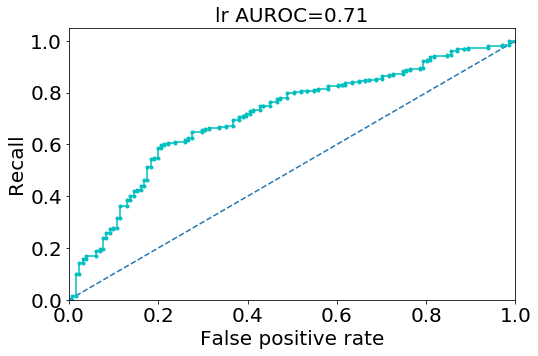

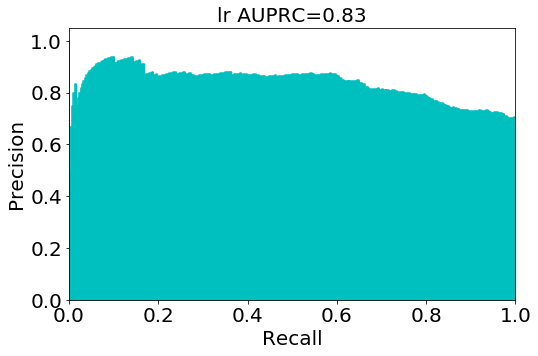

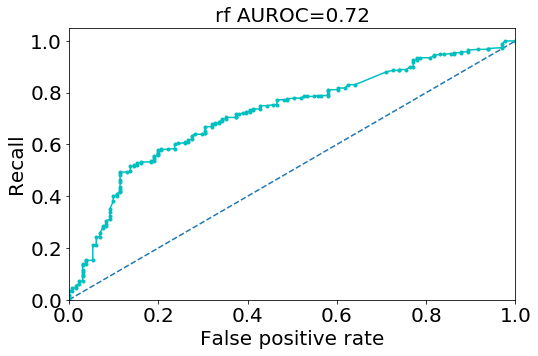

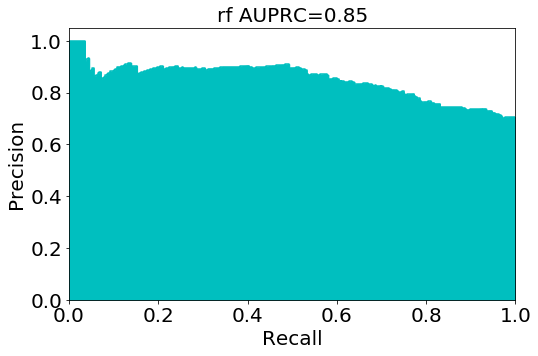

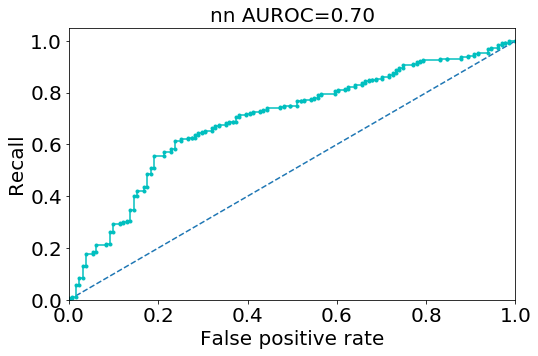

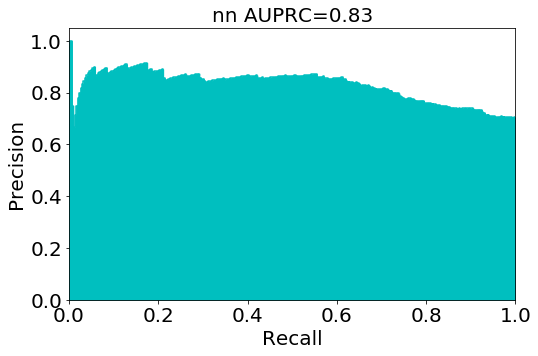

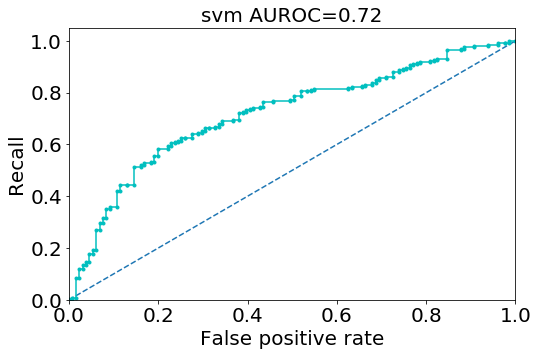

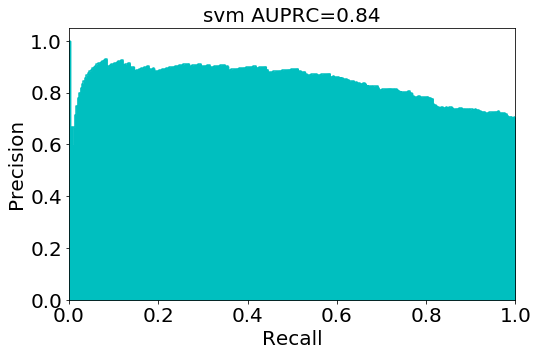

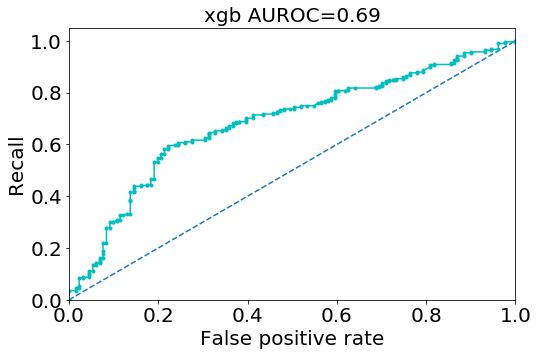

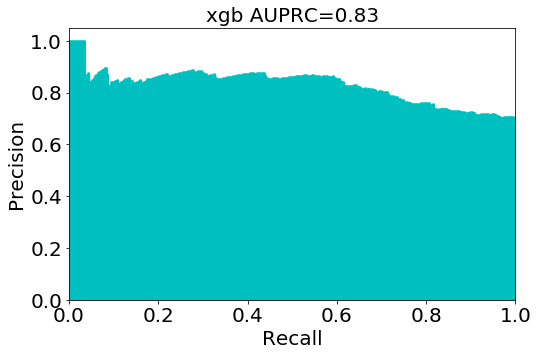

In [18]:
for i,model in enumerate(bestmodels):
    modelname = all_models_names[i]
    print(modelname)
    y_train_pred = model.predict_proba(X_train)[:,1]
    y_test_pred = model.predict_proba(X_test)[:,1]
    auroc(y_test, y_test_pred,all_models_names[i])
    aupr(y_test, y_test_pred,all_models_names[i])
    # Threshold in train
    threshold = optimal_threshold_auc(y_train, y_train_pred)
    
   # performance_all = [roc_auc_score,average_precision_score, accuracy_score, spec, 
   #                sens, precision_score, f1_score, cohen_kappa_score,metric_SMR,metric_aupr] 
   # 
   # performance_names_all = np.array(['roc_auc_score','average_precision_score'
   #                               ,' accuracy_score',' spec','sens',' precision_score'
   #                               ,' f1_score',' cohen_kappa_score','metric_SMR','metric_aupr'])
   # 
    performance = [roc_auc_score,precision_score, spec, sens] 
    
    performance_names = np.array(['roc_auc_score','precision_score','spec','sens'])
    
    
    conf = []
    delt = []
    met = []
    med = []
    te = []
    performance_insights = []
    
    y_test = np.array(y_test)
    
    for i,p in enumerate(performance):
        
        if (p == roc_auc_score or p == average_precision_score or p == metric_aupr):
            mediana,extremes,delta = get_CI_boot(y_test,y_test_pred,p,boot=100) #atencao aqui ao boot
            met.append(p)
            conf.append(extremes)
            delt.append(delta)
            med.append(mediana)
            te.append(p(y_test,y_test_pred)) 
            performance_insights.append(performance_names[i]+' '+str(round(p(y_test,y_test_pred), 2)) +' CI ['+ str(round(extremes[0], 2))  +'-'+  str(round(extremes[1], 2)) +']')
        else:
            y_pred_threshold = (y_test_pred >= threshold).astype(np.int)
            mediana,extremes,delta = get_CI_boot(y_test,y_pred_threshold,p,boot=100)
            met.append(p)
            conf.append(extremes)
            delt.append(delta)
            med.append(mediana)
            te.append(p(y_test,y_pred_threshold)) 
            performance_insights.append(performance_names[i]+' '+str(round(p(y_test,y_pred_threshold), 2)) +' CI ['+ str(round(extremes[0], 2))  +'-'+  str(round(extremes[1], 2)) +']')
            
    
    performance_insights =  str(performance_insights)
    performance_insights = performance_insights.replace("'", "")
    print(performance_insights)    

Save results

In [20]:

db_name = 'OR'


# XGB
model_name = 'XGB'

features_name = 'full'


# Best model
filename = '{}_{}_{}_model.sav'.format(model_name,features_name,db_name)

with open(filename, 'wb') as pickle_file:
    dill.dump(random_search.best_estimator_, pickle_file)
    print('model saved')
    
# CV model
filename = '{}_{}_{}model_CV.sav'.format(model_name,features_name,db_name)

with open(filename, 'wb') as pickle_file:
    dill.dump(random_search, pickle_file)
    print('model saved') 

model saved
model saved


### Explanability of the model

In [21]:
model= LogisticRegression(C=0.1, random_state=42, tol=1.0, verbose=1,
                                     warm_start=True)
model.fit(X_train, y_train)

print(model.coef_[0])


[-0.0954921   0.00531933  0.00191876  0.00455529  0.06500593 -0.00952803
  0.00745607 -0.00687507  1.70194386]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [22]:
print(model.intercept_)

[0.00811226]


In [23]:
pd.DataFrame(model.coef_[0], X_train.columns, columns = ['Coeff'])

,Coeff
gender,-0.095492
age,0.005319
admissionweight,0.001919
admissionheight,0.004555
ethnicity,0.065006
noninvasivesystolic,-0.009528
noninvasivediastolic,0.007456
noninvasivemean,-0.006875
cardioDiagnosis,1.701944
